In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import h5py

# tf.get_logger().setLevel('ERROR')
# !curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

# Import dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input,MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

In [ ]:
path = '/content/drive/MyDrive'
os.chdir(path)

In [ ]:
# Move dataset to /tmp cause reading files from Drive is very slow
!cp vietnamese-foods.zip /tmp
!unzip -q /tmp/vietnamese-foods.zip -d /tmp

# Setup path

In [ ]:
TRAIN_PATH = '/tmp/Images/Train'
VALIDATE_PATH = '/tmp/Images/Validate'
TEST_PATH = '/tmp/Images/Test'

In [ ]:
PATH = '/content/drive/MyDrive/kqcv'

BASE_MODEL_BEST = os.path.join(PATH, '21022015_Xception_best.hdf5')
BASE_MODEL_TRAINED = os.path.join(PATH, '210220154_Xception.hdf5')
Weight_MODEL_TRAINED = os.path.join(PATH, '210220154_Xception_weight.hdf5')
BASE_MODEL_FIG = os.path.join(PATH, '210220154_Xception_fig.jpg')

# Preparing data

In [ ]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64

In [ ]:

train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    # width_shift_range = 0.1,
    # height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,

)
validate_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
generated_train_data = train_generator.flow_from_directory(TRAIN_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_validate_data = validate_generator.flow_from_directory(VALIDATE_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_test_data = test_generator.flow_from_directory(TEST_PATH, target_size=IMAGE_SIZE)

Found 17581 images belonging to 30 classes.
Found 2515 images belonging to 30 classes.
Found 5040 images belonging to 30 classes.


# Model implement

In [ ]:
CLASSES = 30
INITIAL_EPOCHS = 9

## Define the model

In [ ]:
input_layer = Input(shape=(300, 300, 3))
pretrained_model = Xception(weights='imagenet', include_top=False, input_tensor=input_layer)
last_output = pretrained_model.output
x = MaxPooling2D(pool_size=(2, 2))(last_output)
x = GlobalAveragePooling2D()(last_output)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)


outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

83683744/83683744 [==============================] - 1s 0us/step


## Callbacks

In [ ]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST,
    save_best_only = True,
    verbose = 1
)

# fine_tune_checkpointer = ModelCheckpoint(
#     filepath = FINE_TUNE_MODEL_BEST,
#     save_best_only = True,
#     verbose = 1,
# )

# Stop if no improvement after 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
relu_cb= ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

## Stage 1: Transfer learning

In [ ]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping, relu_cb],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)
model.save_weights(Weight_MODEL_TRAINED)

Epoch 1/9
274/274 [==============================] - ETA: 0s - loss: 1.7366 - accuracy: 0.4808
Epoch 1: val_loss improved from inf to 1.34729, saving model to /content/drive/MyDrive/kqcv/21022015_Xception_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 675s 2s/step - loss: 1.7366 - accuracy: 0.4808 - val_loss: 1.3473 - val_accuracy: 0.5893 - lr: 0.0010
Epoch 2/9
274/274 [==============================] - ETA: 0s - loss: 1.2632 - accuracy: 0.6159
Epoch 2: val_loss improved from 1.34729 to 1.19785, saving model to /content/drive/MyDrive/kqcv/21022015_Xception_best.hdf5
274/274 [==============================] - 634s 2s/step - loss: 1.2632 - accuracy: 0.6159 - val_loss: 1.1978 - val_accuracy: 0.6470 - lr: 0.0010
Epoch 3/9
274/274 [==============================] - ETA: 0s - loss: 1.1297 - accuracy: 0.6519
Epoch 3: val_loss improved from 1.19785 to 1.16805, saving model to /content/drive/MyDrive/kqcv/21022015_Xception_best.hdf5
274/274 [==============================] - 630s 2s/step - loss: 1.1297 - accuracy: 0.6519 - val_loss: 1.1681 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 4/9
274/274 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.6784
Epoch 4: val_loss improved from 

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

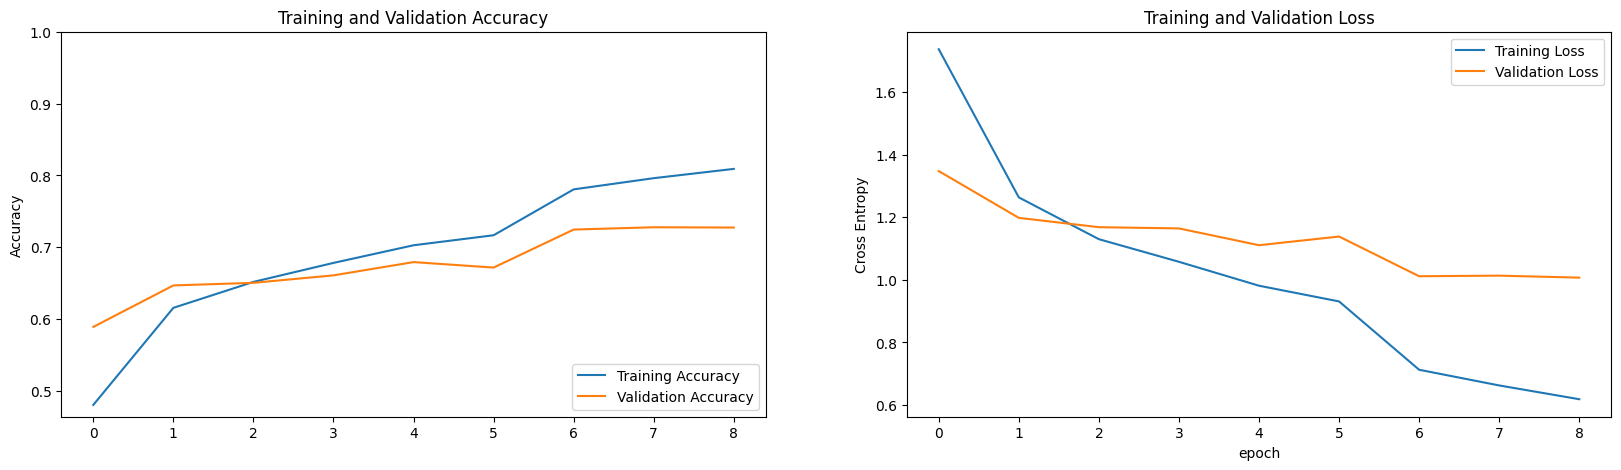

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(BASE_MODEL_FIG)
plt.show()

# Evaluation

In [ ]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

158/158 [==============================] - 90s 534ms/step - loss: 0.9699 - accuracy: 0.7264
Test accuracy: 0.7263888716697693
